# Class 3: Clustering Algorithms for Cybersecurity


### Learning Objectives
By the end of this session, you will be able to:
- Understand the mathematical foundations of clustering algorithms
- Apply K-means, GMM, and DBSCAN to cybersecurity data
- Recognize when different clustering approaches fail or succeed
- Select appropriate clustering methods based on data characteristics
- Implement cluster validation techniques

### Our Agenda
**Problem**: Detecting unknown cyber threats in high-dimensional data

**Approach**: Unsupervised learning to find patterns and anomalies

**Methods**: K-means → GMM → DBSCAN (increasing sophistication)

# Setup and Imports

In [ ]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestNeighbors
from yellowbrick.cluster import KElbowVisualizer
import umap.umap_ as umap
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries loaded successfully!")
print("Ready to explore clustering algorithms for cybersecurity")

Libraries loaded successfully!
Ready to explore clustering algorithms for cybersecurity


# Part 1: The Foundation - Understanding the Problem

## 1.1 Why Clustering Matters in Cybersecurity

**The Challenge**: Most cybersecurity data is unlabeled
- Network traffic logs: Millions of flows, which are attacks?
- User behavior: What constitutes "normal" vs "suspicious"?
- System events: Which patterns indicate compromise?

**The Solution**: Unsupervised learning to find natural groupings and outliers

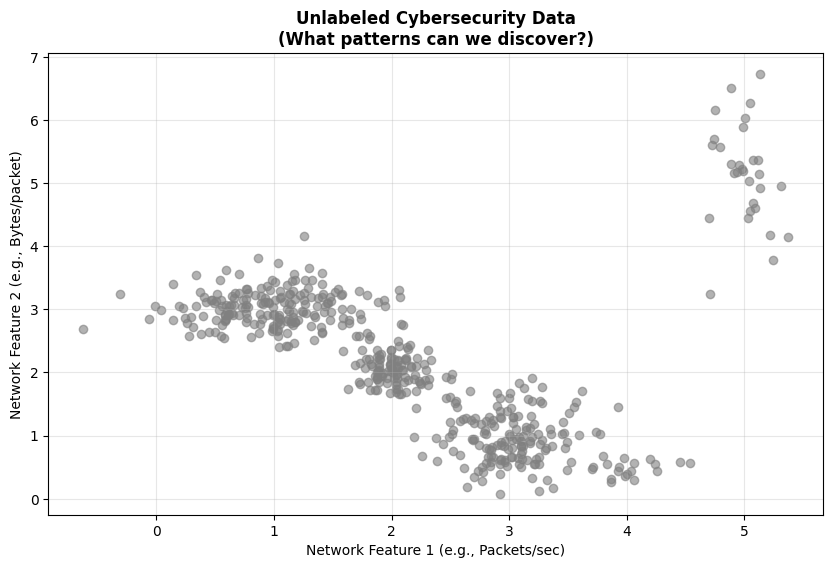

Dataset: 500 network flows with 2 features
Goal: Discover patterns and identify potential attacks without knowing labels


In [ ]:
# Create synthetic cybersecurity-like data to demonstrate the problem
np.random.seed(42)

# Simulate different types of network behavior
normal_web = np.random.normal([1, 3], [0.5, 0.3], (200, 2))  # Normal web traffic
normal_email = np.random.normal([3, 1], [0.3, 0.4], (150, 2))  # Normal email traffic
normal_file = np.random.normal([2, 2], [0.2, 0.2], (100, 2))   # Normal file transfers

# Simulate attacks (unknown to us initially)
ddos_attack = np.random.normal([5, 5], [0.2, 0.8], (30, 2))    # DDoS pattern
data_exfil = np.random.normal([4, 0.5], [0.3, 0.1], (20, 2))   # Data exfiltration

# Combine all data (in real world, we wouldn't know the labels)
X_cyber = np.vstack([normal_web, normal_email, normal_file, ddos_attack, data_exfil])
true_labels = np.hstack([
    np.zeros(200),      # Normal web
    np.ones(150),       # Normal email
    np.full(100, 2),    # Normal file
    np.full(30, 3),     # DDoS (attack)
    np.full(20, 4)      # Exfiltration (attack)
])

# Plot the "unknown" data
plt.figure(figsize=(10, 6))
plt.scatter(X_cyber[:, 0], X_cyber[:, 1], c='gray', alpha=0.6)
plt.title('Unlabeled Cybersecurity Data\n(What patterns can we discover?)', fontweight='bold')
plt.xlabel('Network Feature 1 (e.g., Packets/sec)')
plt.ylabel('Network Feature 2 (e.g., Bytes/packet)')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Dataset: {X_cyber.shape[0]} network flows with {X_cyber.shape[1]} features")
print("Goal: Discover patterns and identify potential attacks without knowing labels")

# Part 2: K-means Clustering - The Foundation

## 2.1 Mathematical Foundation

**K-means Objective**: Minimize within-cluster sum of squares (WCSS)

$$J = \sum_{i=1}^{k} \sum_{x \in C_i} ||x - \mu_i||^2$$

Where:
- $k$ = number of clusters
- $C_i$ = cluster $i$
- $\mu_i$ = centroid of cluster $i$
- $||x - \mu_i||^2$ = squared Euclidean distance

**Algorithm Steps**:
1. Initialize $k$ centroids randomly
2. Assign each point to nearest centroid
3. Update centroids to cluster means: $\mu_i = \frac{1}{|C_i|} \sum_{x \in C_i} x$
4. Repeat steps 2-3 until convergence

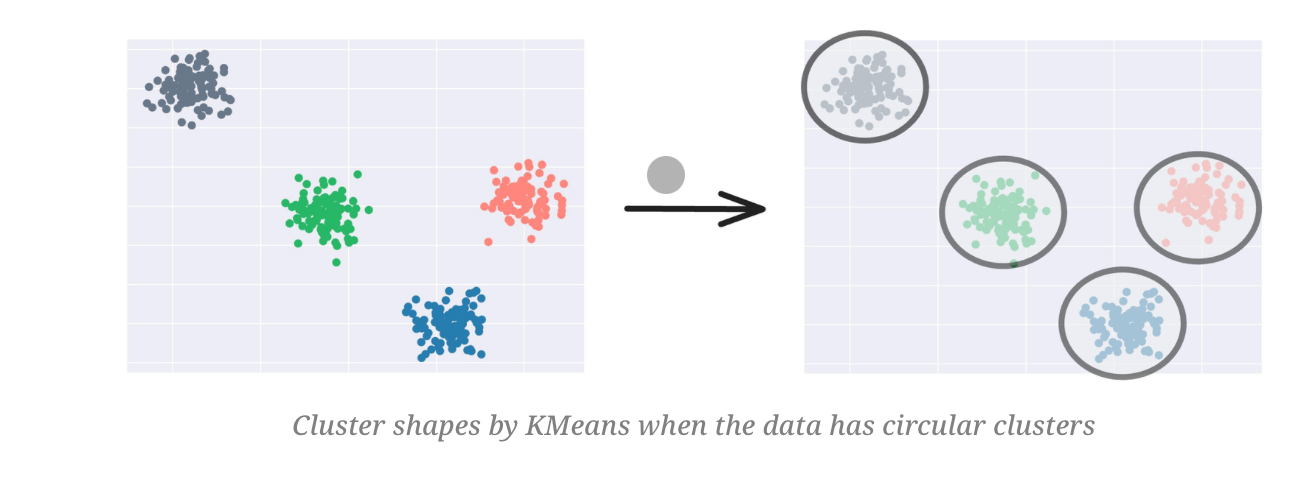

**K-means Algorithm Visualization**
Watch how centroids move and clusters form...
Converged after 6 iterations


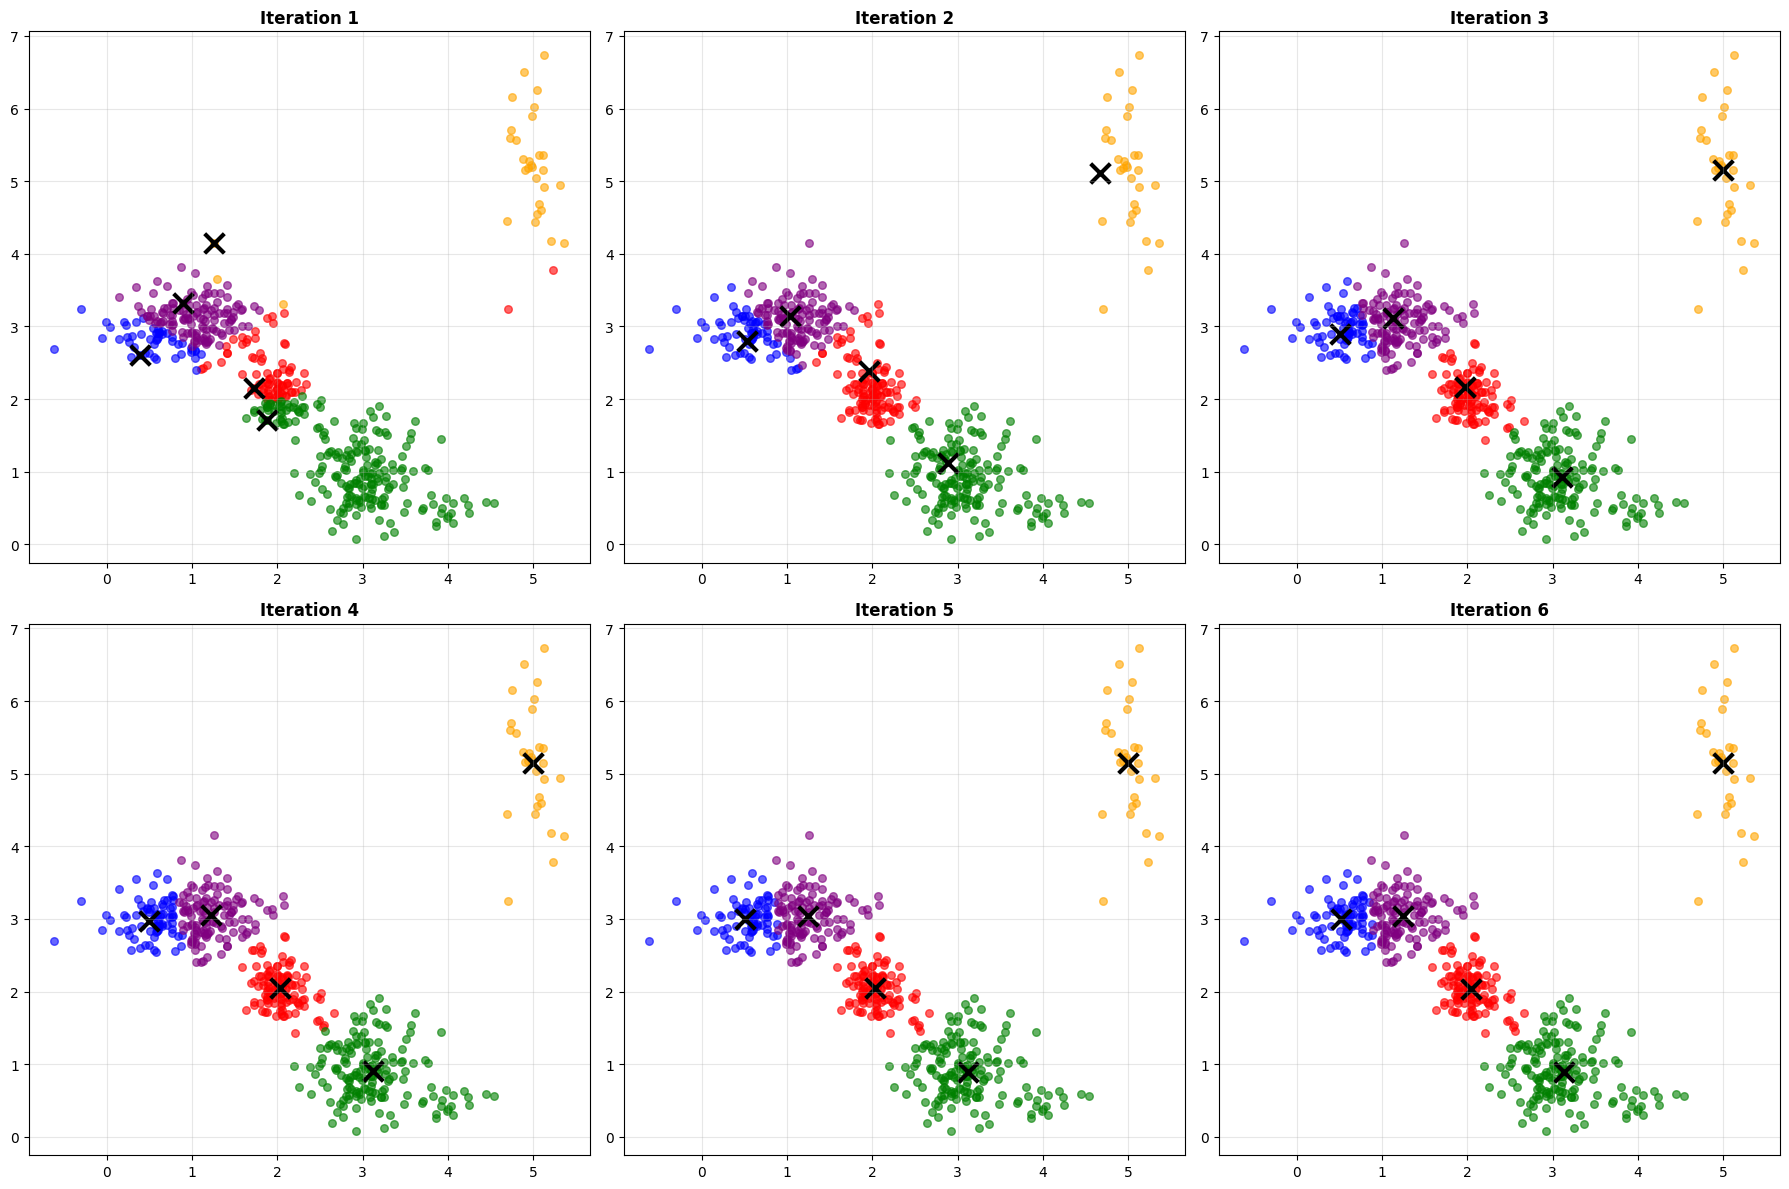

ValueError: operands could not be broadcast together with shapes (500,2) (5,2) 

In [ ]:
def demonstrate_kmeans_algorithm(X, k=3, max_iters=10):
    """Visualize K-means algorithm step by step"""

    # Initialize centroids randomly
    np.random.seed(42)
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    for iteration in range(min(6, max_iters)):
        # Assign points to nearest centroid
        distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
        labels = np.argmin(distances, axis=0)

        # Plot current state
        ax = axes[iteration]
        colors = ['red', 'blue', 'green', 'purple', 'orange']

        for i in range(k):
            mask = labels == i
            ax.scatter(X[mask, 0], X[mask, 1], c=colors[i], alpha=0.6, s=30)
            ax.scatter(centroids[i, 0], centroids[i, 1], c='black', marker='x', s=200, linewidths=3)

        ax.set_title(f'Iteration {iteration + 1}', fontweight='bold')
        ax.grid(True, alpha=0.3)

        # Update centroids
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])

        # Check for convergence
        if np.allclose(centroids, new_centroids, rtol=1e-4):
            print(f"Converged after {iteration + 1} iterations")
            break

        centroids = new_centroids

    plt.tight_layout()
    plt.show()

    return labels, centroids

# Demonstrate K-means on our cyber data
print("**K-means Algorithm Visualization**")
print("Watch how centroids move and clusters form...")

kmeans_labels, final_centroids = demonstrate_kmeans_algorithm(X_cyber, k=5)

# Calculate final WCSS
wcss = sum(np.min(np.sum((X_cyber - final_centroids)**2, axis=1).reshape(-1, 1), axis=1))
print(f"\nFinal WCSS: {wcss:.2f}")

### Key K-Means Hyperparameters

| **Parameter** | **Description** | **Default** | **Impact** |
|---------------|----------------|-------------|------------|
| `n_clusters` | Number of clusters (k) | **Must specify** | **Critical:** Determines cluster count |
| `init` | Centroid initialization | `'k-means++'` | Affects convergence speed/quality |
| `n_init` | Number of random initializations | `10` | Helps avoid local minima |
| `max_iter` | Maximum iterations | `300` | Controls convergence |
| `tol` | Convergence tolerance | `1e-4` | Stopping criteria precision |

## 2.2 The Parameter Selection Challenge

**The Problem**: How do we choose $k$ (number of clusters)?

### Elbow Method
**Principle**: Plot WCSS vs $k$, look for "elbow" where improvement diminishes

### Silhouette Analysis  
**Silhouette Coefficient**: $s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}$

Where:
- $a(i)$ = average intra-cluster distance for point $i$
- $b(i)$ = average distance to nearest cluster for point $i$
- Range: $[-1, 1]$ (higher is better)

**Analyzing optimal number of clusters...**


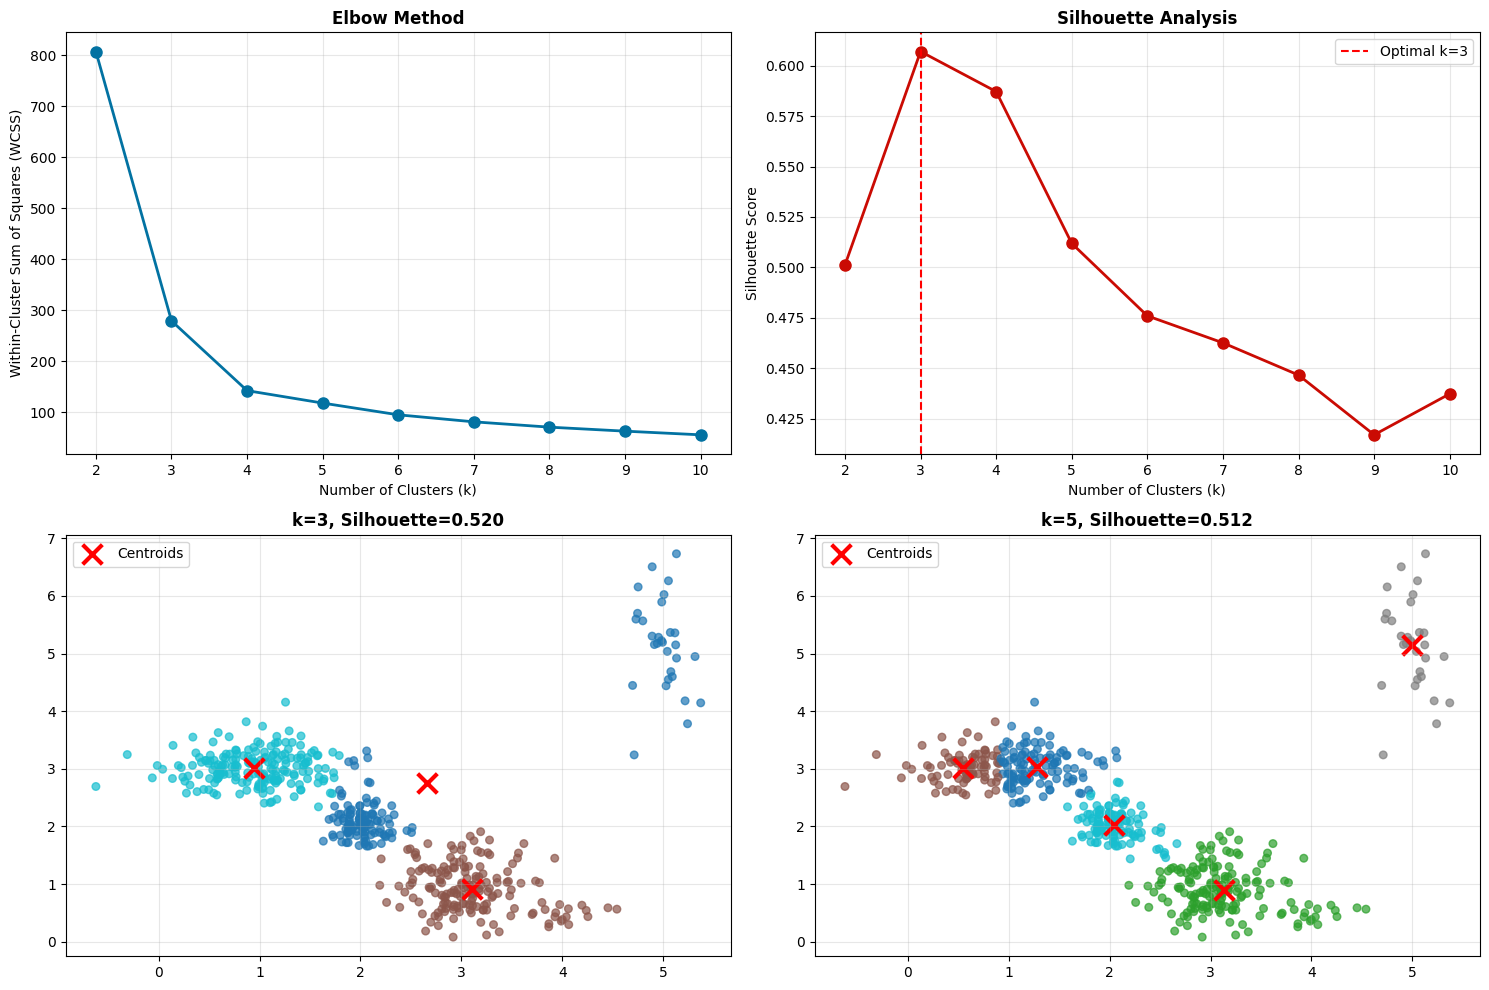


**Analysis Results:**
Optimal k (silhouette): 3
Best silhouette score: 0.607
True number of groups: 5 (3 normal + 2 attacks)


In [ ]:
def comprehensive_cluster_analysis(X, max_k=10):
    """Perform both elbow method and silhouette analysis"""

    k_range = range(2, max_k + 1)
    wcss_values = []
    silhouette_scores = []

    print("**Analyzing optimal number of clusters...**")

    # Calculate metrics for each k
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)

        wcss_values.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, labels))

    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Elbow plot
    axes[0, 0].plot(k_range, wcss_values, 'bo-', linewidth=2, markersize=8)
    axes[0, 0].set_xlabel('Number of Clusters (k)')
    axes[0, 0].set_ylabel('Within-Cluster Sum of Squares (WCSS)')
    axes[0, 0].set_title('Elbow Method', fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)

    # Silhouette plot
    axes[0, 1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
    axes[0, 1].set_xlabel('Number of Clusters (k)')
    axes[0, 1].set_ylabel('Silhouette Score')
    axes[0, 1].set_title('Silhouette Analysis', fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)

    # Mark optimal points
    optimal_silhouette_k = k_range[np.argmax(silhouette_scores)]
    axes[0, 1].axvline(x=optimal_silhouette_k, color='red', linestyle='--',
                      label=f'Optimal k={optimal_silhouette_k}')
    axes[0, 1].legend()

    # Show results with different k values
    test_k_values = [3, 5, 7]
    for idx, k in enumerate(test_k_values[:2]):
        ax = axes[1, idx]
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)

        scatter = ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='tab10', alpha=0.7, s=30)
        ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                  c='red', marker='x', s=200, linewidths=3, label='Centroids')

        sil_score = silhouette_score(X, labels)
        ax.set_title(f'k={k}, Silhouette={sil_score:.3f}', fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return optimal_silhouette_k, max(silhouette_scores)

# Apply to our cybersecurity data
optimal_k, best_silhouette = comprehensive_cluster_analysis(X_cyber)

print(f"\n**Analysis Results:**")
print(f"Optimal k (silhouette): {optimal_k}")
print(f"Best silhouette score: {best_silhouette:.3f}")
print(f"True number of groups: 5 (3 normal + 2 attacks)")

## 2.3 When K-means Fails

**K-means Assumptions**:
1. Clusters are spherical (circular/elliptical)
2. Clusters have similar sizes
3. Clusters have similar densities
4. Features are equally important

**Real-world cybersecurity data often violates these assumptions!**

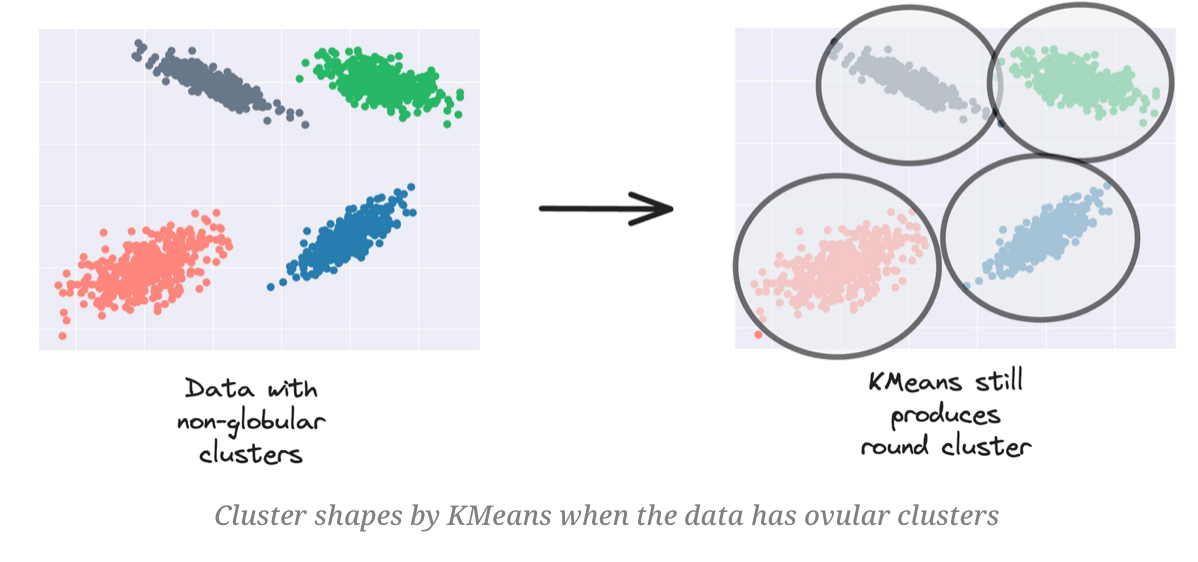

**When K-means Struggles: Cybersecurity Scenarios**


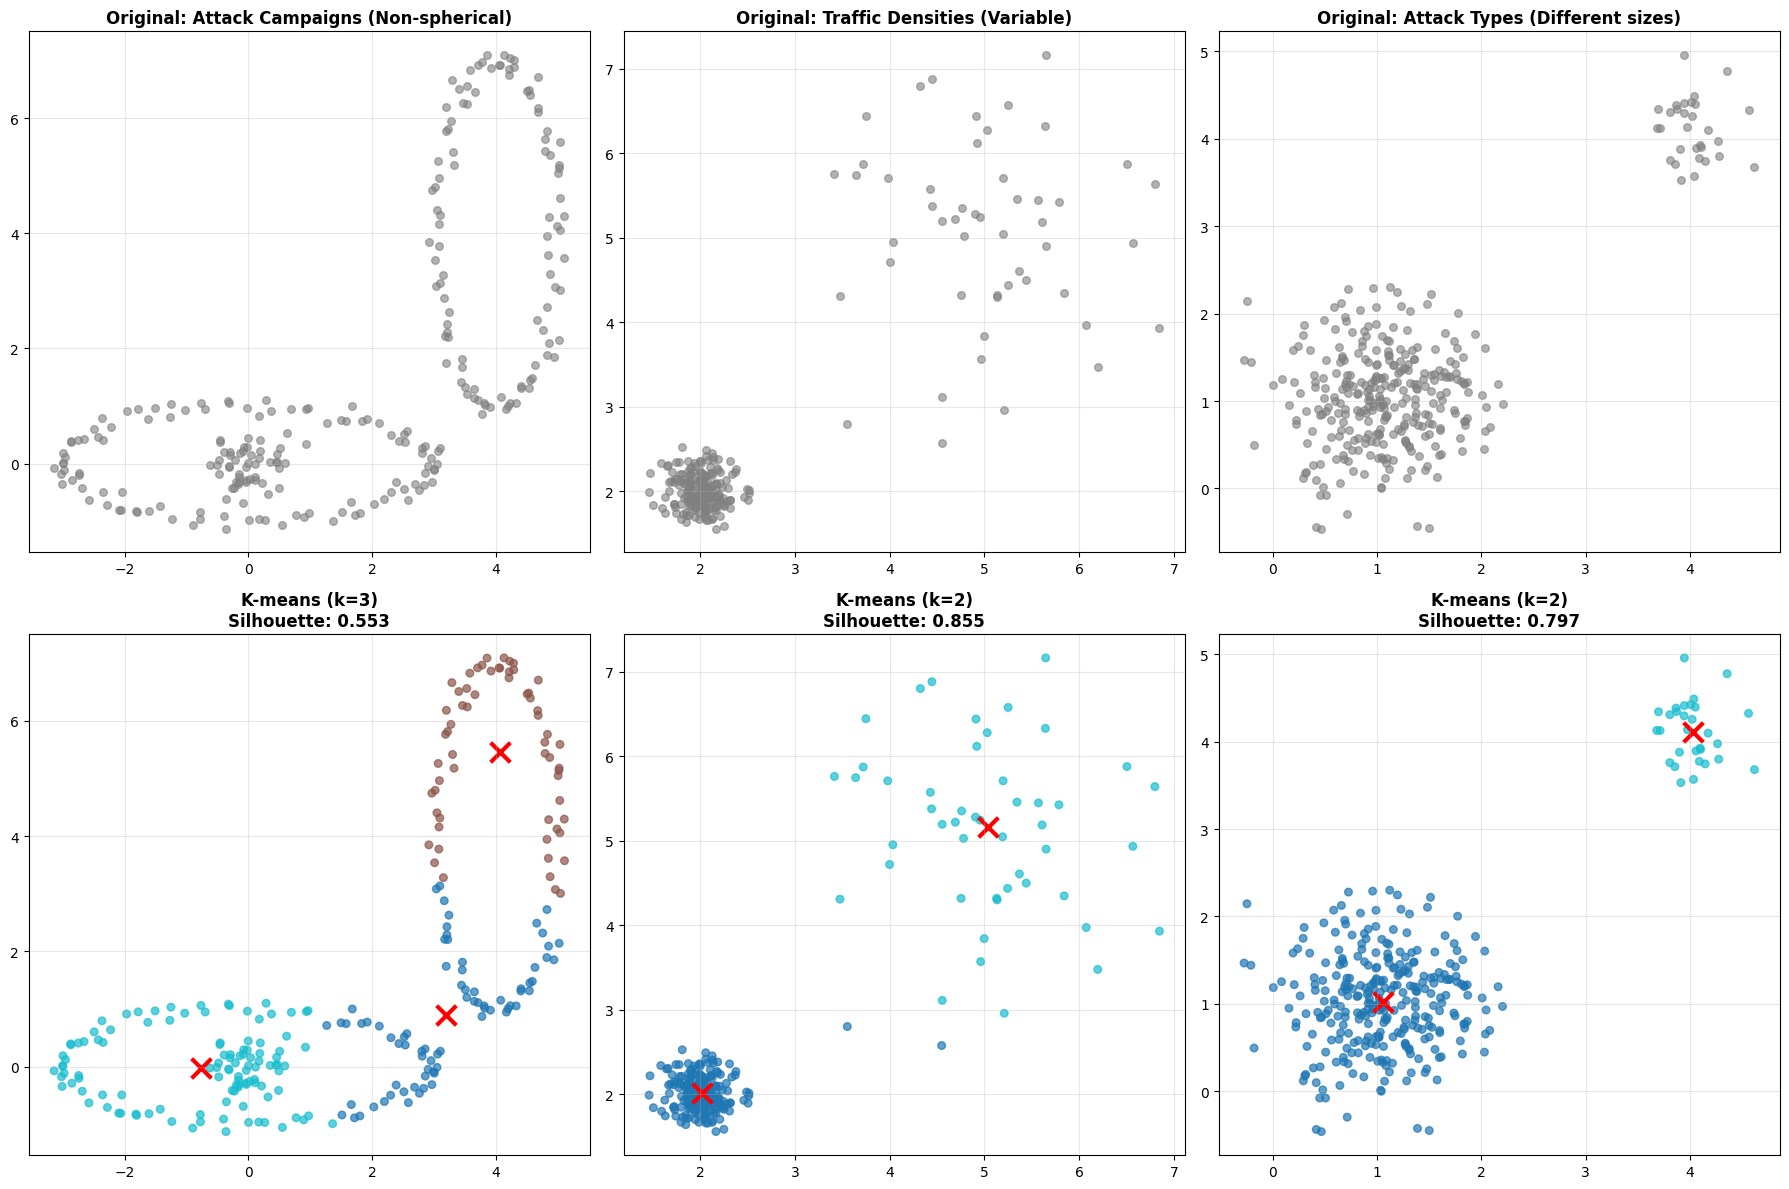


**Key Insight**: K-means assumes spherical, similar-sized clusters
**Cybersecurity Reality**: Attack patterns are often irregular and varied


In [ ]:
def create_challenging_datasets():
    """Create datasets where K-means struggles"""

    np.random.seed(42)

    # Dataset 1: Non-spherical clusters (attack campaigns)
    t = np.linspace(0, 2*np.pi, 100)
    cluster1 = np.column_stack([3*np.cos(t), np.sin(t)]) + np.random.normal(0, 0.1, (100, 2))
    cluster2 = np.column_stack([np.cos(t), 3*np.sin(t)]) + [4, 4] + np.random.normal(0, 0.1, (100, 2))
    cluster3 = np.random.normal([0, 0], 0.3, (50, 2))
    X_nonspherical = np.vstack([cluster1, cluster2, cluster3])

    # Dataset 2: Different densities (normal vs attack traffic)
    dense_cluster = np.random.normal([2, 2], 0.2, (200, 2))  # Dense normal traffic
    sparse_cluster = np.random.normal([5, 5], 1.0, (50, 2))   # Sparse attack traffic
    X_diff_density = np.vstack([dense_cluster, sparse_cluster])

    # Dataset 3: Different sizes (major vs minor attack types)
    large_cluster = np.random.normal([1, 1], 0.5, (300, 2))
    small_cluster = np.random.normal([4, 4], 0.3, (30, 2))
    X_diff_sizes = np.vstack([large_cluster, small_cluster])

    return X_nonspherical, X_diff_density, X_diff_sizes

def compare_kmeans_performance(datasets, titles, true_k_values):
    """Compare K-means performance on challenging datasets"""

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    for idx, (X, title, k) in enumerate(zip(datasets, titles, true_k_values)):
        # Original data
        axes[0, idx].scatter(X[:, 0], X[:, 1], c='gray', alpha=0.6, s=30)
        axes[0, idx].set_title(f'Original: {title}', fontweight='bold')
        axes[0, idx].grid(True, alpha=0.3)

        # K-means results
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)

        scatter = axes[1, idx].scatter(X[:, 0], X[:, 1], c=labels, cmap='tab10', alpha=0.7, s=30)
        axes[1, idx].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                           c='red', marker='x', s=200, linewidths=3)

        sil_score = silhouette_score(X, labels)
        axes[1, idx].set_title(f'K-means (k={k})\nSilhouette: {sil_score:.3f}', fontweight='bold')
        axes[1, idx].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Create and analyze challenging datasets
print("**When K-means Struggles: Cybersecurity Scenarios**")

X_nonspherical, X_diff_density, X_diff_sizes = create_challenging_datasets()

datasets = [X_nonspherical, X_diff_density, X_diff_sizes]
titles = ['Attack Campaigns (Non-spherical)', 'Traffic Densities (Variable)', 'Attack Types (Different sizes)']
k_values = [3, 2, 2]

compare_kmeans_performance(datasets, titles, k_values)

print("\n**Key Insight**: K-means assumes spherical, similar-sized clusters")
print("**Cybersecurity Reality**: Attack patterns are often irregular and varied")

# Part 3: Gaussian Mixture Models - Adding Flexibility


![image.png](https://miro.medium.com/v2/resize:fit:753/1*lTv7e4Cdlp738X_WFZyZHA.png)

## 3.1 Mathematical Foundation

**GMM assumes data comes from a mixture of Gaussian distributions**

**Probability density function**:
$$p(x) = \sum_{k=1}^{K} \pi_k \mathcal{N}(x | \mu_k, \sigma_k)$$

Where:
- $\pi_k$ = mixing coefficient (weight) for component $k$
- $\mathcal{N}(x | \mu_k, \sigma_k)$ = multivariate Gaussian with mean $\mu_k$ and covariance $\sigma_k$
- $\sum_{k=1}^{K} \pi_k = 1$

**Multivariate Gaussian**:
$$\mathcal{N}(x | \mu, \Sigma) = \frac{1}{(2\pi)^{d/2}|\sigma|^{1/2}} \exp\left(-\frac{1}{2}(x-\mu)^T\sigma^{-1}(x-\mu)\right)$$

**Key Advantages over K-means**:
1. **Soft clustering**: Points can belong to multiple clusters with probabilities
2. **Flexible shapes**: Elliptical clusters (not just circular)
3. **Variable sizes**: Different cluster covariances
4. **Uncertainty quantification**: Probability of cluster membership

**GMM vs K-means: Handling Complex Cluster Shapes**


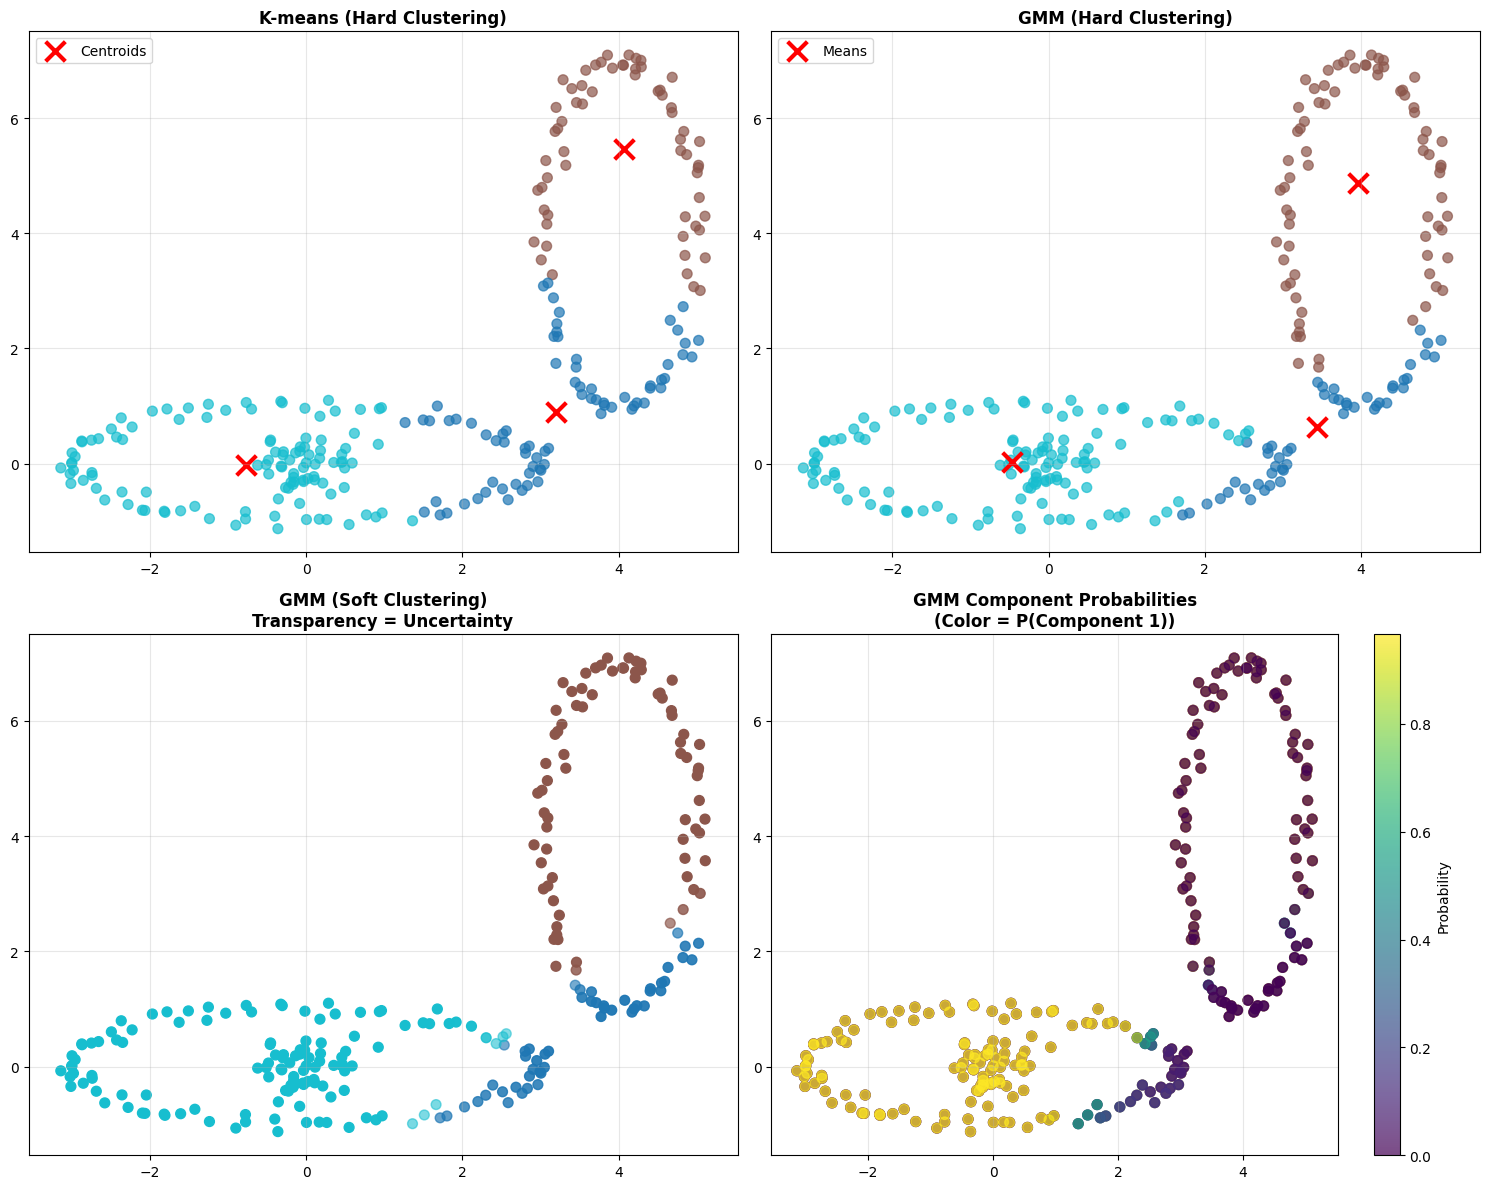


**Performance Comparison:**
K-means Silhouette: 0.553
GMM Silhouette: 0.482

**GMM Advantages:**
- Provides uncertainty measures
- Handles elliptical clusters
- Soft cluster assignments

**Mathematical Insight:**
K-means minimizes: Σ||x - μ||²
GMM maximizes: Σ log[Σπₖ N(x|μₖ,Σₖ)]
Result: GMM can model elliptical clusters with different orientations


In [ ]:
def demonstrate_gmm_vs_kmeans(X):
    """Compare GMM and K-means on the same data"""

    # Apply both methods
    k = 3

    # K-means
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_labels = kmeans.fit_predict(X)

    # GMM
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X)
    gmm_labels = gmm.predict(X)
    gmm_probs = gmm.predict_proba(X)

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # K-means hard clustering
    scatter = axes[0, 0].scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='tab10', alpha=0.7, s=50)
    axes[0, 0].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                      c='red', marker='x', s=200, linewidths=3, label='Centroids')
    axes[0, 0].set_title('K-means (Hard Clustering)', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # GMM hard clustering
    scatter = axes[0, 1].scatter(X[:, 0], X[:, 1], c=gmm_labels, cmap='tab10', alpha=0.7, s=50)
    axes[0, 1].scatter(gmm.means_[:, 0], gmm.means_[:, 1],
                      c='red', marker='x', s=200, linewidths=3, label='Means')
    axes[0, 1].set_title('GMM (Hard Clustering)', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # GMM soft clustering - show uncertainty
    # Use maximum probability as color intensity
    max_probs = np.max(gmm_probs, axis=1)
    scatter = axes[1, 0].scatter(X[:, 0], X[:, 1], c=gmm_labels, cmap='tab10',
                               alpha=max_probs, s=50)  # Alpha shows certainty
    axes[1, 0].set_title('GMM (Soft Clustering)\nTransparency = Uncertainty', fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)

    # Show probability distributions for each component
    for i in range(k):
        component_probs = gmm_probs[:, i]
        scatter = axes[1, 1].scatter(X[:, 0], X[:, 1], c=component_probs,
                                   cmap='viridis', alpha=0.7, s=50)
        if i == 0:  # Only show colorbar for first component
            plt.colorbar(scatter, ax=axes[1, 1], label='Probability')
    axes[1, 1].set_title(f'GMM Component Probabilities\n(Color = P(Component 1))', fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Compare performance
    kmeans_sil = silhouette_score(X, kmeans_labels)
    gmm_sil = silhouette_score(X, gmm_labels)

    print(f"\n**Performance Comparison:**")
    print(f"K-means Silhouette: {kmeans_sil:.3f}")
    print(f"GMM Silhouette: {gmm_sil:.3f}")
    print(f"\n**GMM Advantages:**")
    print(f"- Provides uncertainty measures")
    print(f"- Handles elliptical clusters")
    print(f"- Soft cluster assignments")

    return gmm_labels, gmm_probs

# Demonstrate on non-spherical data
print("**GMM vs K-means: Handling Complex Cluster Shapes**")
gmm_labels, gmm_probs = demonstrate_gmm_vs_kmeans(X_nonspherical)

# Show mathematical insight
print(f"\n**Mathematical Insight:**")
print(f"K-means minimizes: Σ||x - μ||²")
print(f"GMM maximizes: Σ log[Σπₖ N(x|μₖ,Σₖ)]")
print(f"Result: GMM can model elliptical clusters with different orientations")

## 3.2 The Parameter Selection Dilemma

**What happens when methods disagree?**

Sometimes elbow method and silhouette analysis suggest different values of $k$. This is common in real-world data and represents an important learning moment.

**When Methods Disagree: A Real-World Challenge**


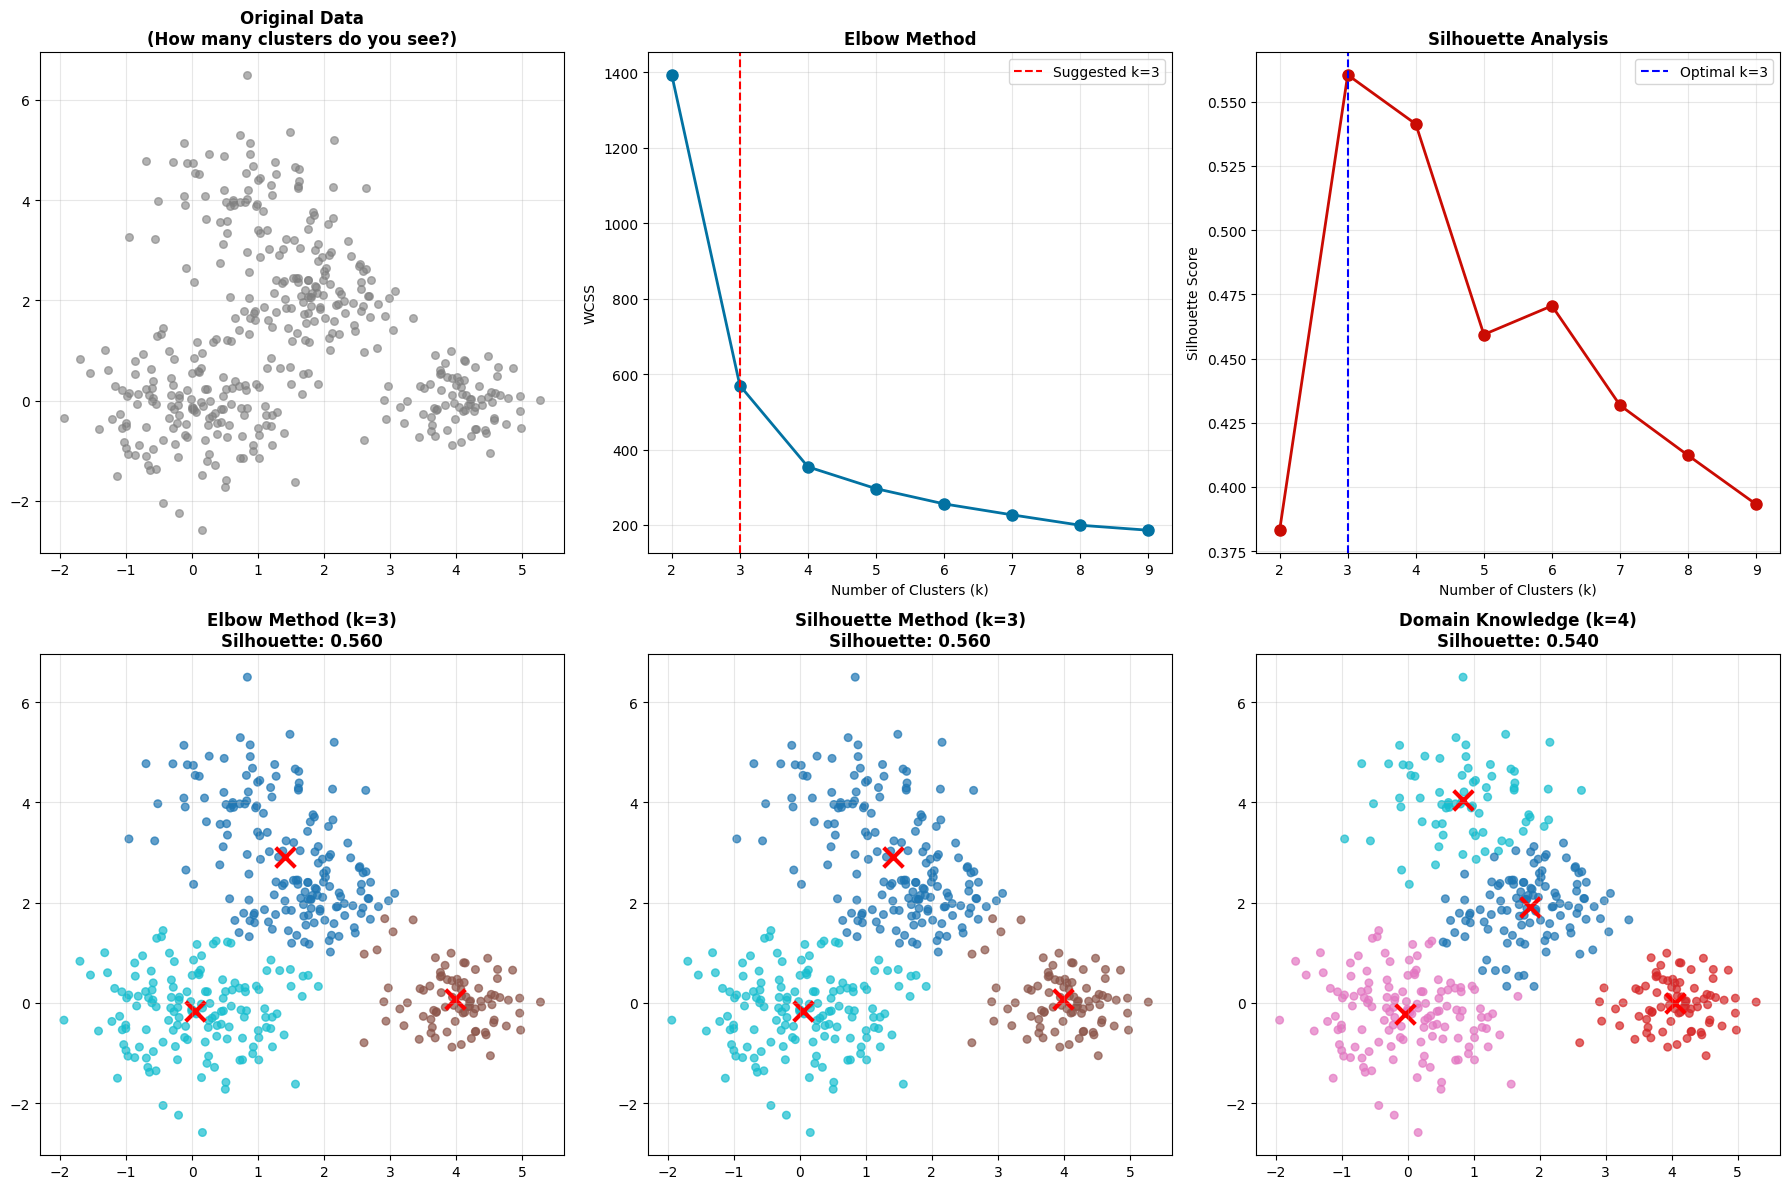


**Method Disagreement Analysis:**
Elbow method suggests: k = 3
Silhouette method suggests: k = 3

**What do we do when methods disagree?**
1. Consider domain knowledge (cybersecurity context)
2. Try multiple values and validate results
3. Use ensemble methods or different algorithms
4. Remember: There might not be a 'perfect' answer!

**Key Learning**: Clustering is often subjective!
**Cybersecurity Insight**: Domain expertise is crucial for validation


In [ ]:
def create_ambiguous_clustering_data():
    """Create data where elbow and silhouette methods might disagree"""

    np.random.seed(123)  # Different seed for different pattern

    # Create overlapping clusters of different sizes
    cluster1 = np.random.normal([0, 0], 0.8, (150, 2))
    cluster2 = np.random.normal([2, 2], 0.6, (100, 2))
    cluster3 = np.random.normal([4, 0], 0.5, (80, 2))
    cluster4 = np.random.normal([1, 4], 0.7, (70, 2))

    X_ambiguous = np.vstack([cluster1, cluster2, cluster3, cluster4])
    return X_ambiguous

def analyze_method_disagreement(X):
    """Analyze case where different methods suggest different k values"""

    k_range = range(2, 10)
    wcss_values = []
    silhouette_scores = []

    # Calculate metrics
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)

        wcss_values.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, labels))

    # Find suggested k values
    # Elbow detection (simplified - look for largest decrease)
    wcss_diff = np.diff(wcss_values)
    elbow_k = k_range[np.argmin(wcss_diff) + 1]

    # Silhouette optimum
    silhouette_k = k_range[np.argmax(silhouette_scores)]

    # Visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Original data
    axes[0, 0].scatter(X[:, 0], X[:, 1], c='gray', alpha=0.6, s=30)
    axes[0, 0].set_title('Original Data\n(How many clusters do you see?)', fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)

    # Elbow plot
    axes[0, 1].plot(k_range, wcss_values, 'bo-', linewidth=2, markersize=8)
    axes[0, 1].axvline(x=elbow_k, color='red', linestyle='--',
                      label=f'Suggested k={elbow_k}')
    axes[0, 1].set_xlabel('Number of Clusters (k)')
    axes[0, 1].set_ylabel('WCSS')
    axes[0, 1].set_title('Elbow Method', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Silhouette plot
    axes[0, 2].plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
    axes[0, 2].axvline(x=silhouette_k, color='blue', linestyle='--',
                      label=f'Optimal k={silhouette_k}')
    axes[0, 2].set_xlabel('Number of Clusters (k)')
    axes[0, 2].set_ylabel('Silhouette Score')
    axes[0, 2].set_title('Silhouette Analysis', fontweight='bold')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # Show results with different k values
    test_k = [elbow_k, silhouette_k, 4]  # Include a middle-ground option
    titles = [f'Elbow Method (k={elbow_k})', f'Silhouette Method (k={silhouette_k})', 'Domain Knowledge (k=4)']

    for i, (k, title) in enumerate(zip(test_k, titles)):
        if i < 3:  # Only show first 3
            ax = axes[1, i]
            kmeans = KMeans(n_clusters=k, random_state=42)
            labels = kmeans.fit_predict(X)

            scatter = ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='tab10', alpha=0.7, s=30)
            ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                      c='red', marker='x', s=200, linewidths=3)

            sil_score = silhouette_score(X, labels)
            ax.set_title(f'{title}\nSilhouette: {sil_score:.3f}', fontweight='bold')
            ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\n**Method Disagreement Analysis:**")
    print(f"Elbow method suggests: k = {elbow_k}")
    print(f"Silhouette method suggests: k = {silhouette_k}")
    print(f"\n**What do we do when methods disagree?**")
    print(f"1. Consider domain knowledge (cybersecurity context)")
    print(f"2. Try multiple values and validate results")
    print(f"3. Use ensemble methods or different algorithms")
    print(f"4. Remember: There might not be a 'perfect' answer!")

    return elbow_k, silhouette_k

# Create and analyze ambiguous case
print("**When Methods Disagree: A Real-World Challenge**")
X_ambiguous = create_ambiguous_clustering_data()
elbow_k, sil_k = analyze_method_disagreement(X_ambiguous)

print(f"\n**Key Learning**: Clustering is often subjective!")
print(f"**Cybersecurity Insight**: Domain expertise is crucial for validation")

# Part 4: DBSCAN - A Different Approach

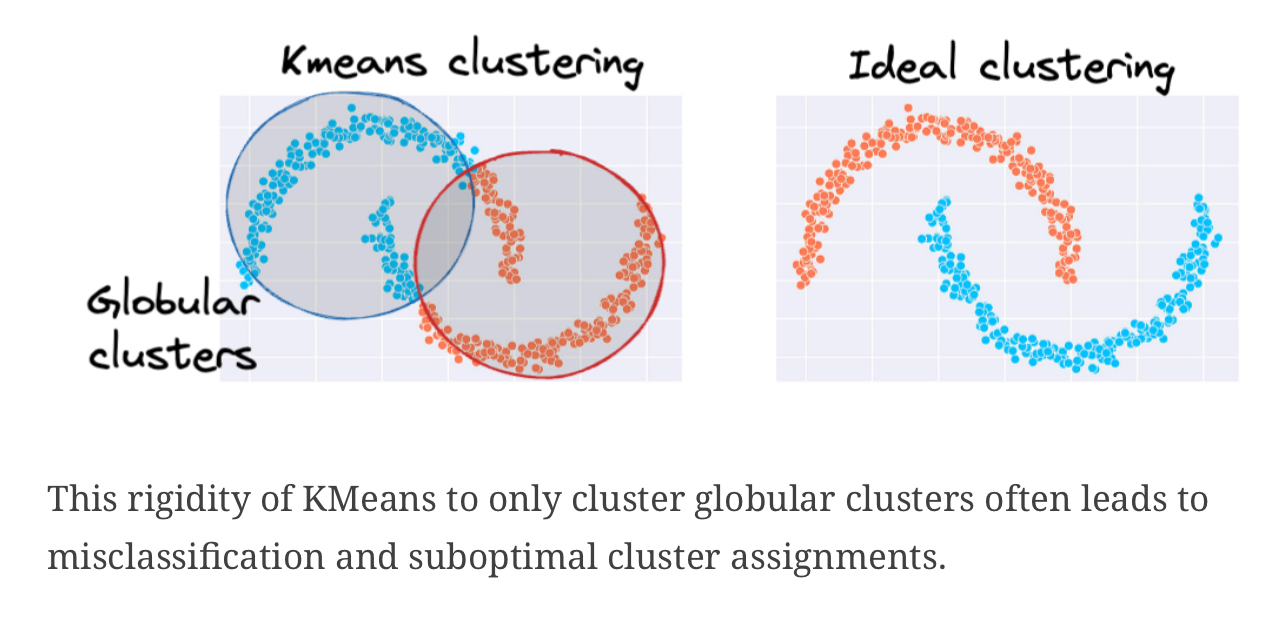

## 4.1 Mathematical Foundation

**DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**

**Key Concepts**:
- **Core Point**: Point with at least `min_samples` neighbors within distance `eps`
- **Border Point**: Non-core point within `eps` of a core point  
- **Noise Point**: Neither core nor border (potential anomalies!)

**Mathematical Definitions**:
- **ε-neighborhood**: $N_{\varepsilon}(p) = \{q \in D | dist(p,q) \leq \varepsilon\}$
- **Core point**: $|N_{\varepsilon}(p)| \geq MinPts$
- **Directly density-reachable**: $q \in N_{\varepsilon}(p)$ and $p$ is core
- **Density-reachable**: Chain of directly density-reachable points

**Algorithm**:
1. For each unvisited point $p$:
2. Find $N_{\varepsilon}(p)$
3. If $|N_{\varepsilon}(p)| \geq MinPts$, start new cluster
4. Add all density-reachable points to cluster
5. Mark isolated points as noise

**Key Advantages**:
- No need to specify number of clusters
- Finds arbitrary cluster shapes
- **Automatically identifies outliers/anomalies**
- Robust to noise

### Key DBSCAN Hyperparameters**

| **Parameter** | **Description** | **Default** | **Impact** |
|---------------|----------------|-------------|------------|
| `eps` | Maximum distance between points | **Must specify** | **Critical:** Controls cluster boundaries |
| `min_samples` | Minimum points in neighborhood | `5` | **Major:** Determines core/noise classification |
| `metric` | Distance metric | `'euclidean'` | How distances are calculated |
| `algorithm` | Neighbor search method | `'auto'` | Performance optimization |

**DBSCAN: Handling Complex Cluster Shapes**
Perfect for cybersecurity data with irregular attack patterns!


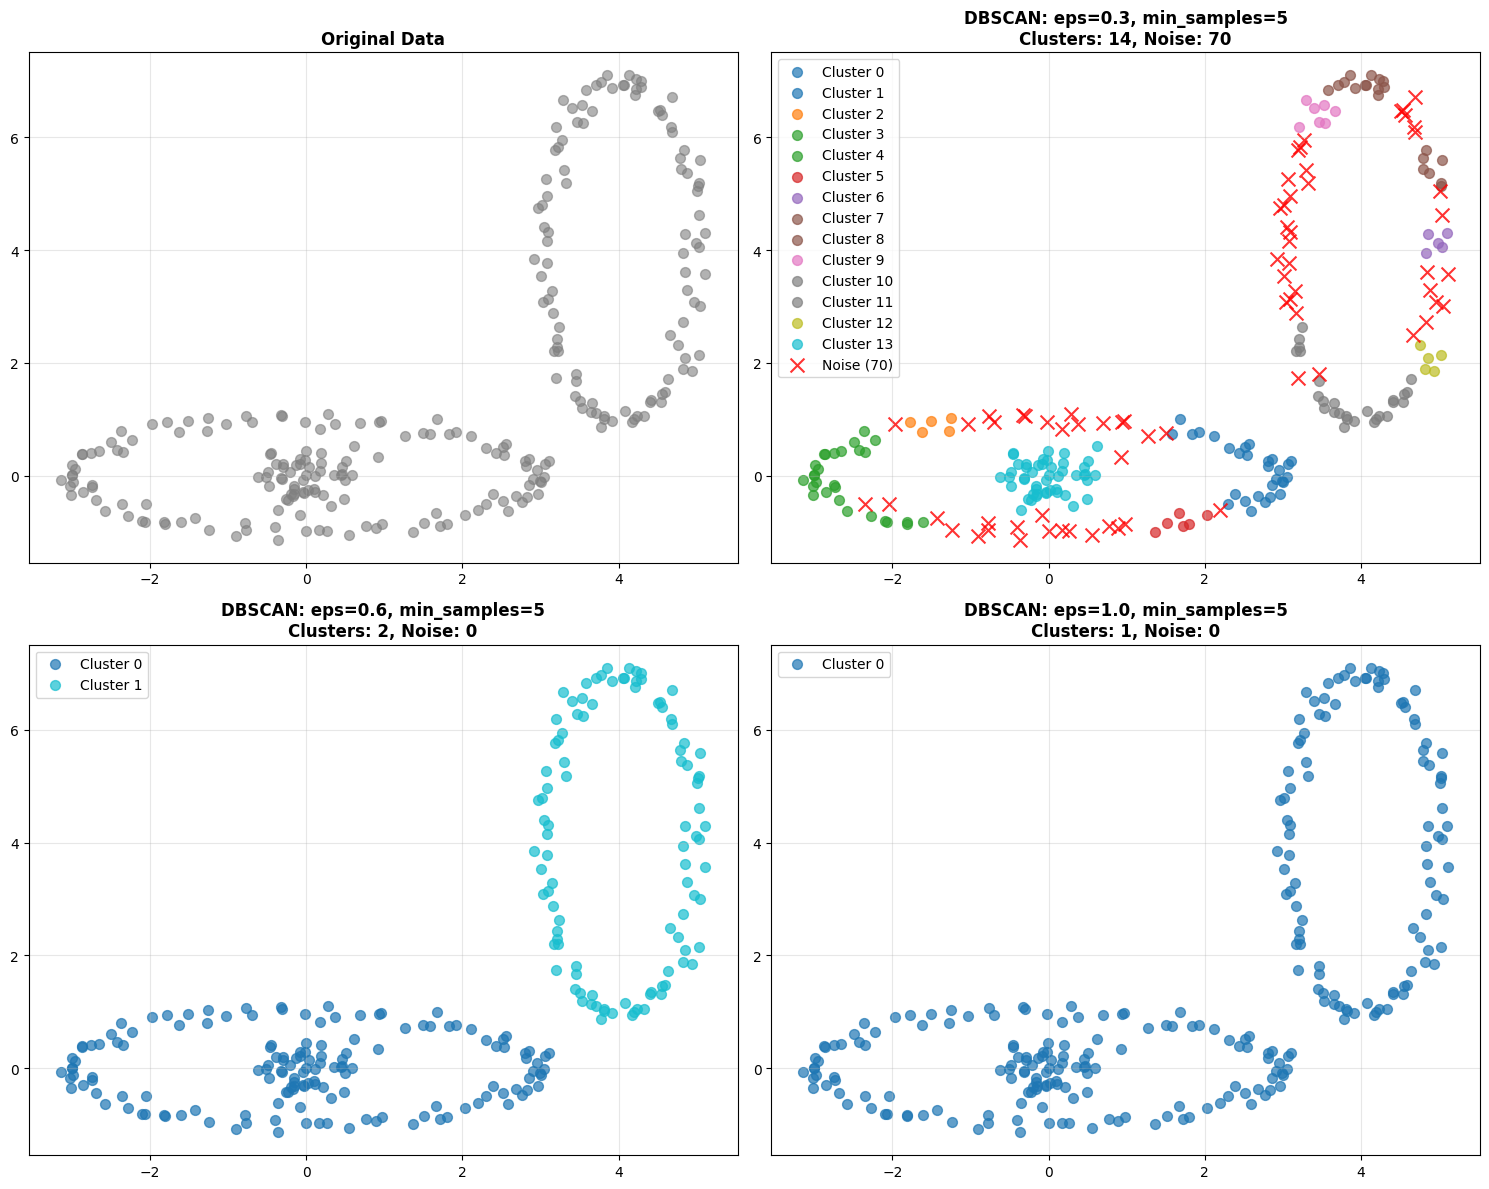


**Finding Optimal eps Parameter**
Method: k-NN distance plot (k = min_samples - 1 = 4)


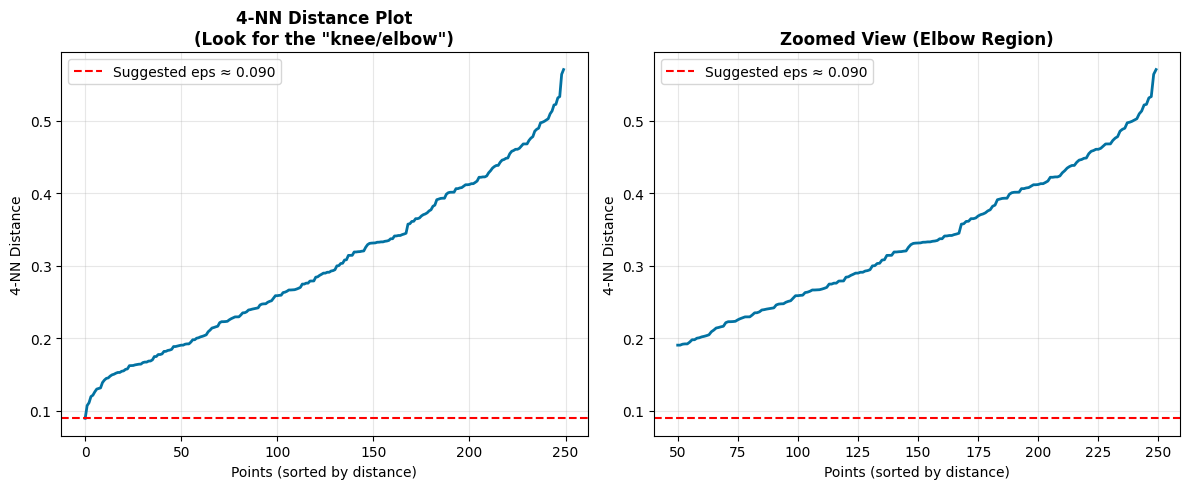


**DBSCAN Key Advantages for Cybersecurity:**
✓ No need to specify number of attack types (clusters)
✓ Finds irregular attack patterns (non-spherical clusters)
✓ Automatically identifies anomalies (noise points)
✓ Robust to outliers in normal traffic


In [ ]:
def demonstrate_dbscan_concepts(X, eps_values=[0.3, 0.6, 1.0], min_samples=5):
    """Visualize DBSCAN concepts and parameter effects"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    # Original data
    axes[0].scatter(X[:, 0], X[:, 1], c='gray', alpha=0.6, s=50)
    axes[0].set_title('Original Data', fontweight='bold')
    axes[0].grid(True, alpha=0.3)

    # Test different eps values
    for i, eps in enumerate(eps_values):
        if i < 3:  # Only show first 3
            ax = axes[i + 1]

            # Apply DBSCAN
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X)

            # Count clusters and noise
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = sum(labels == -1)

            # Plot results
            unique_labels = set(labels)
            colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

            for label, color in zip(unique_labels, colors):
                if label == -1:
                    # Noise points (black x's)
                    mask = labels == label
                    ax.scatter(X[mask, 0], X[mask, 1], c='red', marker='x', s=100,
                              alpha=0.8, label=f'Noise ({n_noise})')
                else:
                    # Cluster points
                    mask = labels == label
                    ax.scatter(X[mask, 0], X[mask, 1], c=[color], s=50, alpha=0.7,
                              label=f'Cluster {label}')

            ax.set_title(f'DBSCAN: eps={eps}, min_samples={min_samples}\n'
                        f'Clusters: {n_clusters}, Noise: {n_noise}', fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.legend()

    plt.tight_layout()
    plt.show()

    return labels

def find_optimal_eps(X, min_samples=5):
    """Find optimal eps using k-NN distance plot"""

    print(f"\n**Finding Optimal eps Parameter**")
    print(f"Method: k-NN distance plot (k = min_samples - 1 = {min_samples-1})")

    # Calculate k-NN distances
    k = min_samples - 1
    neighbors = NearestNeighbors(n_neighbors=k + 1)  # +1 because point is its own neighbor
    neighbors.fit(X)
    distances, indices = neighbors.kneighbors(X)

    # Get k-th nearest neighbor distances (excluding self)
    k_distances = distances[:, k]
    k_distances = np.sort(k_distances)

    # Plot k-NN distance plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(k_distances, 'b-', linewidth=2)
    plt.xlabel('Points (sorted by distance)')
    plt.ylabel(f'{k}-NN Distance')
    plt.title(f'{k}-NN Distance Plot\n(Look for the "knee/elbow")', fontweight='bold')
    plt.grid(True, alpha=0.3)

    # Suggest eps value (where curve starts to rise steeply)
    # Find point where gradient increases significantly
    gradients = np.gradient(k_distances)
    steep_start = np.where(gradients > np.percentile(gradients, 95))[0]

    if len(steep_start) > 0:
        suggested_eps = k_distances[steep_start[0]]
        plt.axhline(y=suggested_eps, color='red', linestyle='--',
                   label=f'Suggested eps ≈ {suggested_eps:.3f}')
        plt.legend()
    else:
        suggested_eps = np.percentile(k_distances, 95)

    # Show zoomed view
    plt.subplot(1, 2, 2)
    zoom_start = max(0, len(k_distances) - 200)
    plt.plot(range(zoom_start, len(k_distances)), k_distances[zoom_start:], 'b-', linewidth=2)
    plt.axhline(y=suggested_eps, color='red', linestyle='--',
               label=f'Suggested eps ≈ {suggested_eps:.3f}')
    plt.xlabel('Points (sorted by distance)')
    plt.ylabel(f'{k}-NN Distance')
    plt.title('Zoomed View (Elbow Region)', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return suggested_eps

# Demonstrate DBSCAN on challenging data
print("**DBSCAN: Handling Complex Cluster Shapes**")
print("Perfect for cybersecurity data with irregular attack patterns!")

# Use non-spherical data to show DBSCAN's strength
dbscan_labels = demonstrate_dbscan_concepts(X_nonspherical)

# Find optimal parameters
optimal_eps = find_optimal_eps(X_nonspherical)

print(f"\n**DBSCAN Key Advantages for Cybersecurity:**")
print(f"✓ No need to specify number of attack types (clusters)")
print(f"✓ Finds irregular attack patterns (non-spherical clusters)")
print(f"✓ Automatically identifies anomalies (noise points)")
print(f"✓ Robust to outliers in normal traffic")

## 4.2 Comprehensive Method Comparison

Now let's compare all three methods on the same challenging dataset to understand their strengths and weaknesses.

**Comprehensive Method Comparison**
Testing all three methods on complex cybersecurity-like data...


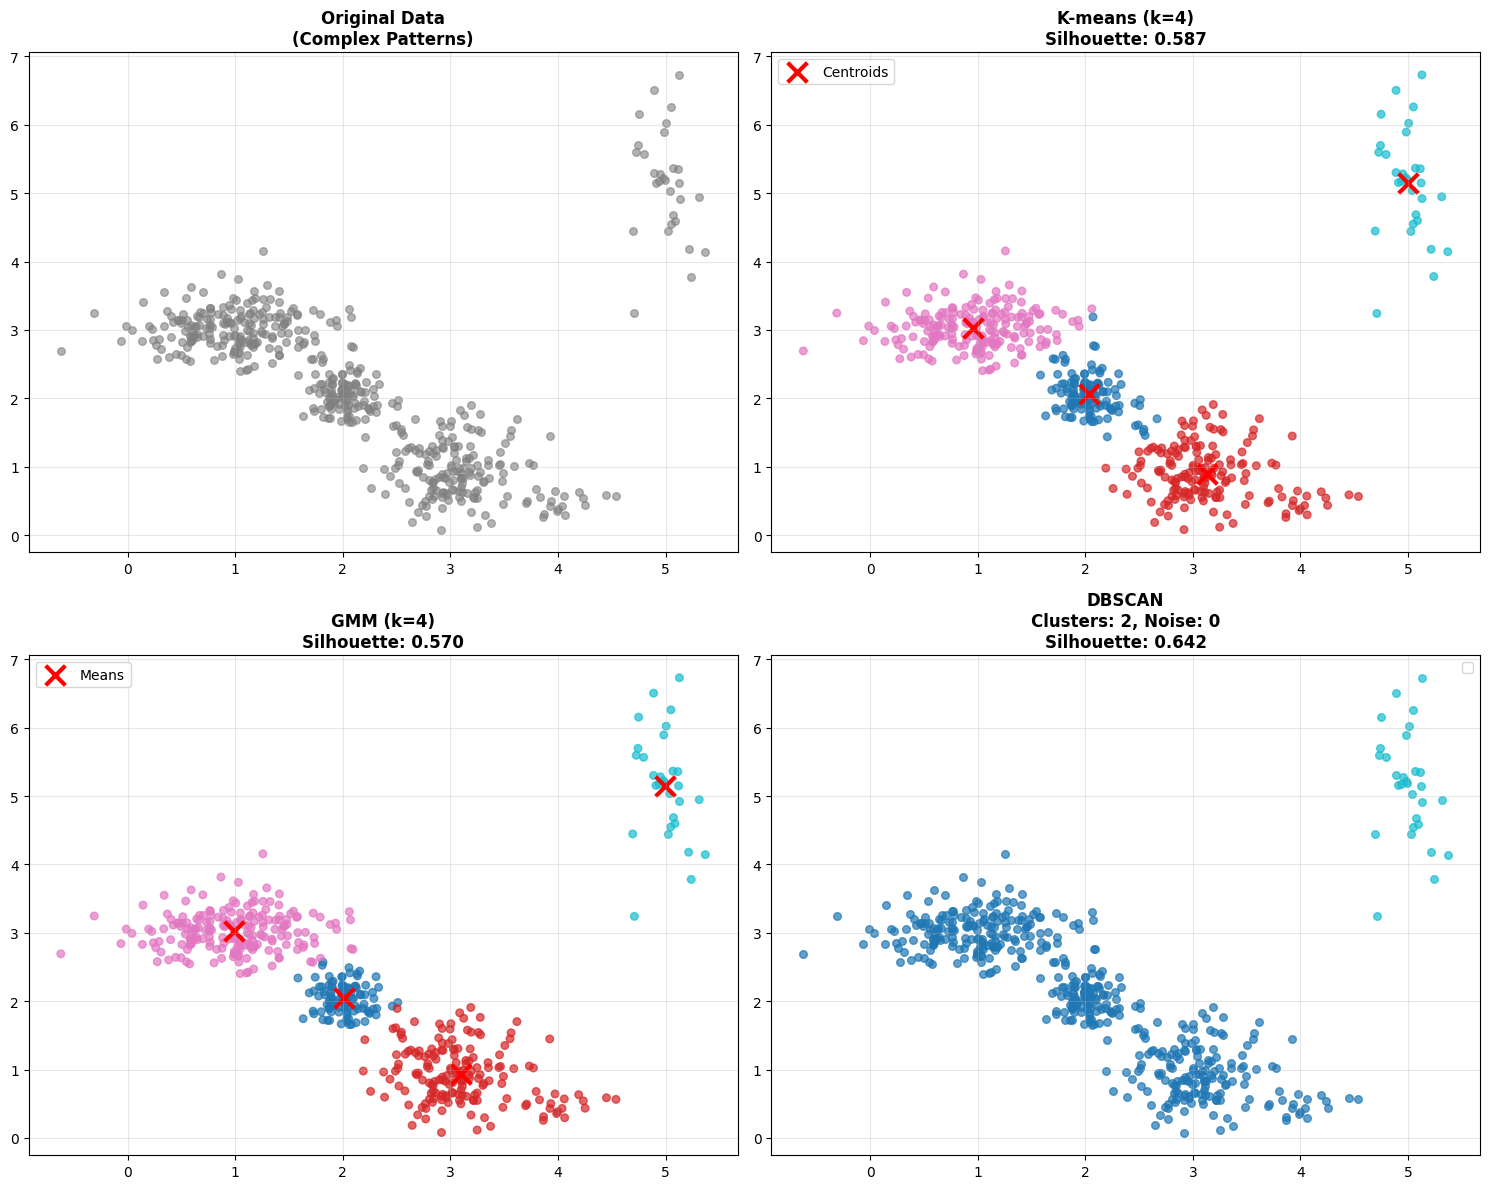


**Method Comparison Summary:**
Method       Clusters   Noise    Silhouette   Key Strength
K-means      4          0        0.587        Fast, simple
GMM          4          0        0.570        Probabilistic, flexible shapes
DBSCAN       2          0        0.642        Auto-detects anomalies

**Key Insights for Cybersecurity:**
• K-means: Good baseline, assumes spherical attack patterns
• GMM: Better for overlapping/uncertain classifications
• DBSCAN: Ideal when attack patterns are irregular & you need anomaly detection

**Decision Framework for Cybersecurity Applications:**

**Choose K-means when:**
• You have a rough idea of number of attack types
• You need fast, interpretable results
• Attack patterns are roughly circular/spherical

**Choose GMM when:**
• You need uncertainty quantification
• Attack patterns have different shapes/orientations
• You want soft cluster assignments

**Choose DBSCAN when:**
• Unknown number of attack types
• Irregular attack patterns expected
• Autom

In [ ]:
def comprehensive_method_comparison(X):
    """Compare K-means, GMM, and DBSCAN on the same dataset"""

    print("**Comprehensive Method Comparison**")
    print("Testing all three methods on complex cybersecurity-like data...")

    # Apply all three methods
    k = 4  # Reasonable guess for number of clusters

    # K-means
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_labels = kmeans.fit_predict(X)

    # GMM
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_labels = gmm.fit_predict(X)

    # DBSCAN (use optimal eps from previous analysis)
    dbscan = DBSCAN(eps=0.8, min_samples=5)
    dbscan_labels = dbscan.fit_predict(X)

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Original data
    axes[0, 0].scatter(X[:, 0], X[:, 1], c='gray', alpha=0.6, s=30)
    axes[0, 0].set_title('Original Data\n(Complex Patterns)', fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)

    # K-means results
    axes[0, 1].scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='tab10', alpha=0.7, s=30)
    axes[0, 1].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                      c='red', marker='x', s=200, linewidths=3, label='Centroids')
    kmeans_sil = silhouette_score(X, kmeans_labels)
    axes[0, 1].set_title(f'K-means (k={k})\nSilhouette: {kmeans_sil:.3f}', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # GMM results
    axes[1, 0].scatter(X[:, 0], X[:, 1], c=gmm_labels, cmap='tab10', alpha=0.7, s=30)
    axes[1, 0].scatter(gmm.means_[:, 0], gmm.means_[:, 1],
                      c='red', marker='x', s=200, linewidths=3, label='Means')
    gmm_sil = silhouette_score(X, gmm_labels)
    axes[1, 0].set_title(f'GMM (k={k})\nSilhouette: {gmm_sil:.3f}', fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # DBSCAN results
    unique_labels = set(dbscan_labels)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

    for label, color in zip(unique_labels, colors):
        if label == -1:
            # Noise points
            mask = dbscan_labels == label
            axes[1, 1].scatter(X[mask, 0], X[mask, 1], c='red', marker='x', s=100,
                              alpha=0.8, label=f'Noise ({sum(mask)})')
        else:
            # Cluster points
            mask = dbscan_labels == label
            axes[1, 1].scatter(X[mask, 0], X[mask, 1], c=[color], s=30, alpha=0.7)

    n_clusters_db = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = sum(dbscan_labels == -1)

    # Calculate silhouette for DBSCAN (excluding noise points)
    if n_clusters_db > 1:
        non_noise_mask = dbscan_labels != -1
        if sum(non_noise_mask) > 0:
            dbscan_sil = silhouette_score(X[non_noise_mask], dbscan_labels[non_noise_mask])
        else:
            dbscan_sil = -1
    else:
        dbscan_sil = -1

    axes[1, 1].set_title(f'DBSCAN\nClusters: {n_clusters_db}, Noise: {n_noise}\nSilhouette: {dbscan_sil:.3f}',
                        fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Performance summary
    print(f"\n**Method Comparison Summary:**")
    print(f"{'Method':<12} {'Clusters':<10} {'Noise':<8} {'Silhouette':<12} {'Key Strength'}")
    print(f"{'='*65}")
    print(f"{'K-means':<12} {k:<10} {'0':<8} {kmeans_sil:<12.3f} Fast, simple")
    print(f"{'GMM':<12} {k:<10} {'0':<8} {gmm_sil:<12.3f} Probabilistic, flexible shapes")
    print(f"{'DBSCAN':<12} {n_clusters_db:<10} {n_noise:<8} {dbscan_sil:<12.3f} Auto-detects anomalies")

    print(f"\n**Key Insights for Cybersecurity:**")
    print(f"• K-means: Good baseline, assumes spherical attack patterns")
    print(f"• GMM: Better for overlapping/uncertain classifications")
    print(f"• DBSCAN: Ideal when attack patterns are irregular & you need anomaly detection")

    return {
        'kmeans': (kmeans_labels, kmeans_sil),
        'gmm': (gmm_labels, gmm_sil),
        'dbscan': (dbscan_labels, dbscan_sil)
    }

# Run comprehensive comparison
comparison_results = comprehensive_method_comparison(X_cyber)

print(f"\n**Decision Framework for Cybersecurity Applications:**")
print(f"\n**Choose K-means when:**")
print(f"• You have a rough idea of number of attack types")
print(f"• You need fast, interpretable results")
print(f"• Attack patterns are roughly circular/spherical")

print(f"\n**Choose GMM when:**")
print(f"• You need uncertainty quantification")
print(f"• Attack patterns have different shapes/orientations")
print(f"• You want soft cluster assignments")

print(f"\n**Choose DBSCAN when:**")
print(f"• Unknown number of attack types")
print(f"• Irregular attack patterns expected")
print(f"• Automatic anomaly detection is priority")
print(f"• Robust outlier handling needed")

# Part 5: Next Steps and Advanced Methods

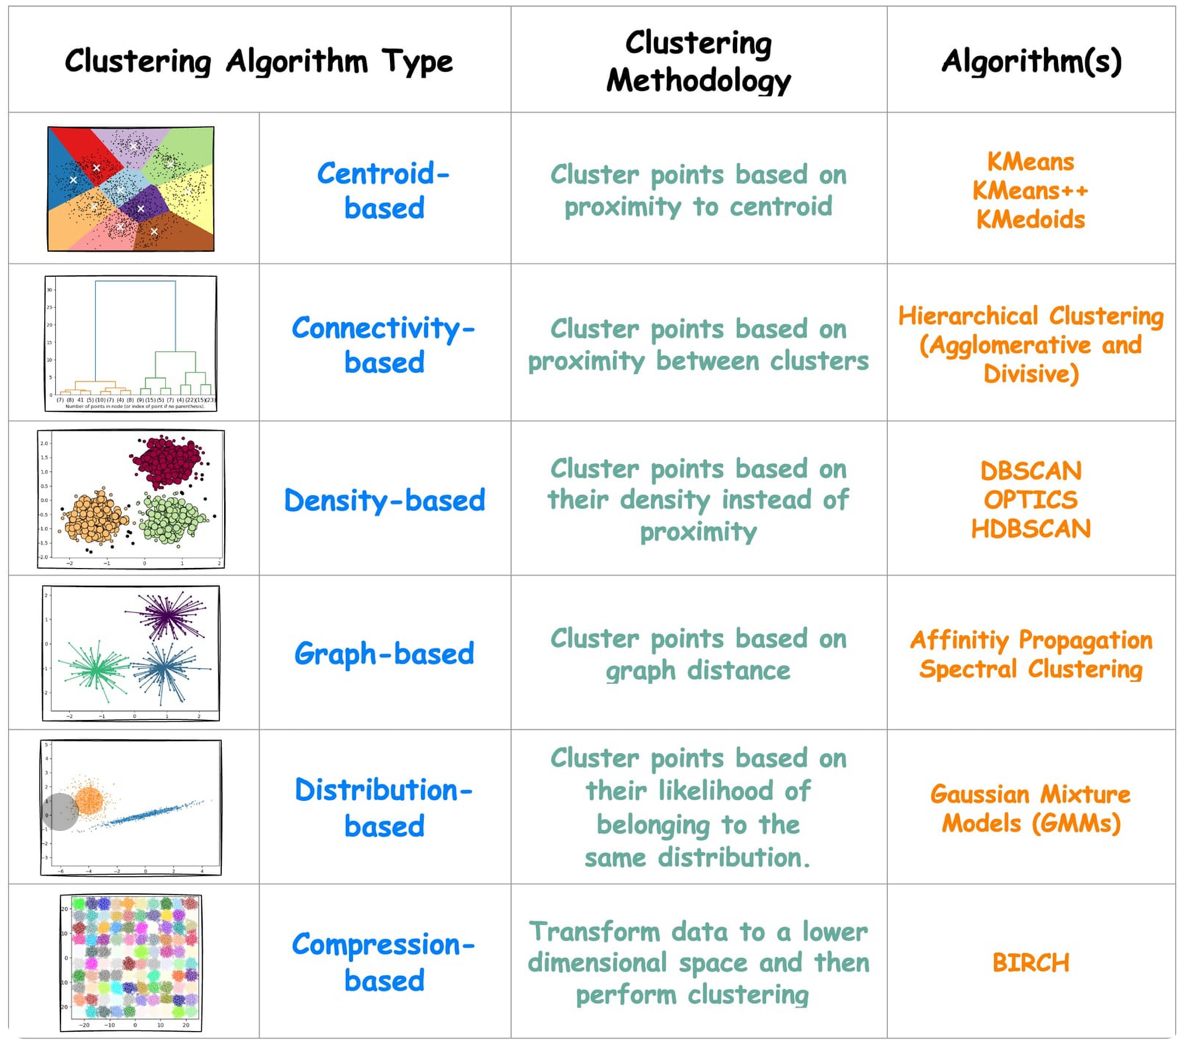

## 5.1 The Clustering Algorithm Landscape

Today we covered three fundamental approaches:
- **Centroid-based**: K-means, K-medoids
- **Distribution-based**: Gaussian Mixture Models (GMM)
- **Density-based**: DBSCAN, OPTICS, HDBSCAN

But there are many more approaches available for different types of problems...

## 5.2 When Traditional Clustering Isn't Enough

**The "Normal Behavior" Problem in Cybersecurity**:
- Network behavior changes constantly
- Seasonal patterns (business hours, weekends)
- Evolution of legitimate applications
- New types of normal behavior emerge

**Traditional clustering limitations**:
- Static models don't adapt
- High-dimensional feature spaces
- Temporal dependencies ignored
- Complex behavioral patterns

**The Challenge: Evolving Normal Behavior**


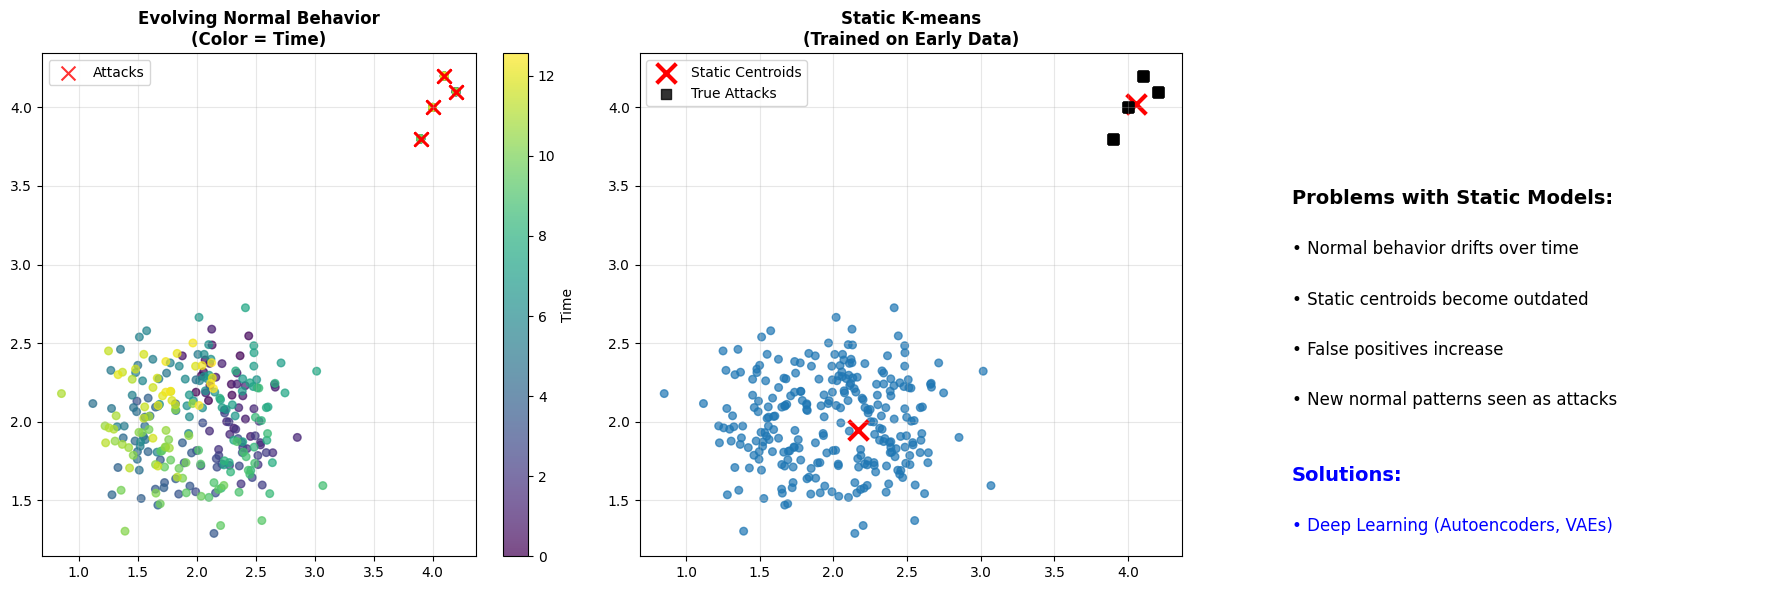


**The Evolution Challenge:**
• Normal behavior patterns change over time
• Static clustering models become outdated
• Need adaptive, continuous learning approaches
• Traditional methods struggle with high-dimensional, temporal data


**PREVIEW: NEXT WEEK - DEEP LEARNING APPROACHES**

**Why Deep Learning for Cybersecurity?**
• Handle high-dimensional feature spaces automatically
• Learn complex, non-linear patterns in data
• Adapt to evolving normal behavior
• Model temporal dependencies and sequences

**Methods we'll explore:**
• **Autoencoders**: Learn compressed representations of normal behavior
• **Variational Autoencoders (VAEs)**: Probabilistic generative models
• **Recurrent Neural Networks**: For temporal/sequential patterns
• **Graph Neural Networks**: For network topology analysis

**Real-world applications:**
• Advanced Persistent Threat (APT) detection
• Zero-day malware identification
• Insider threat detection
• Network intrusion detection systems

**Today's Foundation +

In [ ]:
# Demonstrate the "normal behavior" challenge
def demonstrate_evolving_behavior():
    """Show how normal behavior can evolve over time"""

    print("**The Challenge: Evolving Normal Behavior**")

    # Simulate network behavior over time
    np.random.seed(42)
    time_points = np.linspace(0, 4*np.pi, 300)

    # Base normal behavior that shifts over time
    normal_x = 2 + 0.5 * np.sin(time_points) + np.random.normal(0, 0.2, 300)
    normal_y = 2 + 0.3 * np.cos(time_points) + np.random.normal(0, 0.2, 300)

    # Add some attacks (fixed pattern)
    attack_x = np.array([4, 4.1, 3.9, 4.2] * 10)[:40]
    attack_y = np.array([4, 4.2, 3.8, 4.1] * 10)[:40]
    attack_times = np.random.choice(range(300), 40, replace=False)

    # Combine data
    X_evolving = np.column_stack([normal_x, normal_y])
    X_evolving[attack_times] = np.column_stack([attack_x, attack_y])

    # Show how static clustering fails
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Time-colored plot
    scatter = axes[0].scatter(X_evolving[:, 0], X_evolving[:, 1],
                             c=time_points, cmap='viridis', alpha=0.7, s=30)
    axes[0].scatter(X_evolving[attack_times, 0], X_evolving[attack_times, 1],
                   c='red', marker='x', s=100, alpha=0.8, label='Attacks')
    plt.colorbar(scatter, ax=axes[0], label='Time')
    axes[0].set_title('Evolving Normal Behavior\n(Color = Time)', fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Static K-means (trained on early data)
    early_data = X_evolving[:100]  # Train on first 100 points
    kmeans_static = KMeans(n_clusters=2, random_state=42)
    early_labels = kmeans_static.fit_predict(early_data)

    # Apply to all data
    all_labels_static = kmeans_static.predict(X_evolving)

    axes[1].scatter(X_evolving[:, 0], X_evolving[:, 1],
                   c=all_labels_static, cmap='tab10', alpha=0.7, s=30)
    axes[1].scatter(kmeans_static.cluster_centers_[:, 0], kmeans_static.cluster_centers_[:, 1],
                   c='red', marker='x', s=200, linewidths=3, label='Static Centroids')
    axes[1].scatter(X_evolving[attack_times, 0], X_evolving[attack_times, 1],
                   c='black', marker='s', s=50, alpha=0.8, label='True Attacks')
    axes[1].set_title('Static K-means\n(Trained on Early Data)', fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Show the problem
    axes[2].text(0.1, 0.7, 'Problems with Static Models:', fontsize=14, fontweight='bold',
                transform=axes[2].transAxes)
    axes[2].text(0.1, 0.6, '• Normal behavior drifts over time', fontsize=12,
                transform=axes[2].transAxes)
    axes[2].text(0.1, 0.5, '• Static centroids become outdated', fontsize=12,
                transform=axes[2].transAxes)
    axes[2].text(0.1, 0.4, '• False positives increase', fontsize=12,
                transform=axes[2].transAxes)
    axes[2].text(0.1, 0.3, '• New normal patterns seen as attacks', fontsize=12,
                transform=axes[2].transAxes)

    axes[2].text(0.1, 0.15, 'Solutions:', fontsize=14, fontweight='bold', color='blue',
                transform=axes[2].transAxes)
    axes[2].text(0.1, 0.05, '• Deep Learning (Autoencoders, VAEs)', fontsize=12, color='blue',
                transform=axes[2].transAxes)
    axes[2].set_xlim(0, 1)
    axes[2].set_ylim(0, 1)
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    print("\n**The Evolution Challenge:**")
    print("• Normal behavior patterns change over time")
    print("• Static clustering models become outdated")
    print("• Need adaptive, continuous learning approaches")
    print("• Traditional methods struggle with high-dimensional, temporal data")

demonstrate_evolving_behavior()

print("\n\n" + "="*60)
print("**PREVIEW: NEXT WEEK - DEEP LEARNING APPROACHES**")
print("="*60)

print("\n**Why Deep Learning for Cybersecurity?**")
print("• Handle high-dimensional feature spaces automatically")
print("• Learn complex, non-linear patterns in data")
print("• Adapt to evolving normal behavior")
print("• Model temporal dependencies and sequences")

print("\n**Methods we'll explore:**")
print("• **Autoencoders**: Learn compressed representations of normal behavior")
print("• **Variational Autoencoders (VAEs)**: Probabilistic generative models")
print("• **Recurrent Neural Networks**: For temporal/sequential patterns")
print("• **Graph Neural Networks**: For network topology analysis")

print("\n**Real-world applications:**")
print("• Advanced Persistent Threat (APT) detection")
print("• Zero-day malware identification")
print("• Insider threat detection")
print("• Network intrusion detection systems")

print(f"\n**Today's Foundation + Next Week's Power = Advanced Cybersecurity AI**")

# Summary: Key Takeaways

## **Mathematical Progression**
1. **K-means**: $\min \sum_{i=1}^{k} \sum_{x \in C_i} ||x - \mu_i||^2$ (Euclidean distance)
2. **GMM**: $\max \sum_{i=1}^{n} \log \sum_{k=1}^{K} \pi_k \mathcal{N}(x_i | \mu_k, \sigma_k)$ (Probabilistic)
3. **DBSCAN**: Density-based, no global optimization function

## **Method Selection Framework**

| Scenario | Method | Reason |
|----------|--------|--------|
| Known attack types, regular patterns | K-means | Fast, interpretable |
| Uncertain classifications, overlapping | GMM | Probabilistic assignments |
| Unknown threats, irregular patterns | DBSCAN | Auto-detects anomalies |
| Evolving behavior, high-dimensional | Deep Learning | Adaptive, complex patterns |

## **Cybersecurity Insights**
- **No perfect clustering method** - context and domain knowledge matter
- **Parameter selection is critical** - elbow/silhouette methods provide guidance
- **Traditional clustering has limits** - evolving threats need adaptive approaches
- **Next frontier**: Deep learning for complex, temporal cybersecurity patterns

---

**Next Session**: Deep Learning approaches for advanced cybersecurity threat detection

**Lab Activity**: Hands-on comparison of all three methods on real cybersecurity datasets

**Homework**: DBSCAN parameter optimization and anomaly analysis